In [1]:
from torch_geometric.data import DataLoader
import torch.distributions as D
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors, rdMolTransforms
from rdkit import rdBase
import glob
import os

from deepdock.utils.distributions import *
from deepdock.utils.data import *
from deepdock.models import *

from deepdock.DockingFunction import optimze_conformation
from scipy.optimize import basinhopping, brute, differential_evolution
import copy

# set the random seeds for reproducibility
np.random.seed(123)
torch.cuda.manual_seed_all(123)
torch.manual_seed(123)

%matplotlib inline

In [2]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

ligand_model = LigandNet(28, residual_layers=10, dropout_rate=0.10)
target_model = TargetNet(4, residual_layers=10, dropout_rate=0.10)
model = DeepDock(ligand_model, target_model, hidden_dim=64, n_gaussians=10, dropout_rate=0.10, dist_threhold=7.).to(device)

checkpoint = torch.load('../Trained_models/DeepDock_pdbbindv2019_13K_minTestLoss.chk')
model.load_state_dict(checkpoint['model_state_dict']) 

<All keys matched successfully>

In [3]:
%%time
db_complex = PDBbind_complex_dataset(data_path='../data/dataset_deepdock_pdbbind_v2019_16K.tar', 
                                     min_target_nodes=50, max_ligand_nodes=None)
#db_complex = [i for i in db_complex if i[3] in checkpoint['pdbIDs_test']]
print('Complexes in Test Set:', len(db_complex))


Complexes in Test Set: 16367
CPU times: user 5.17 s, sys: 3.52 s, total: 8.69 s
Wall time: 44 s


In [4]:
%%time
loader = DataLoader(db_complex, batch_size=1, shuffle=False)
dist_threshold=3.
popsize=150

for data in loader:
    if data[3][0] == '2rka':
        np.random.seed(123)
        torch.cuda.manual_seed_all(123)
        torch.manual_seed(123)
    
        model.eval()
        ligand, target, activity, pdbid = data
        ligand, target = ligand.to(device), target.to(device)
        pi, sigma, mu, dist, atom_types, bond_types, batch = model(ligand, target)
    
        pdb_id = pdbid[0]
        real_mol = Chem.MolFromMol2File('../../DeepDock/data/pdbbind_v2019_other_refined/' + pdb_id + '/' + pdb_id +'_ligand.mol2',
                                        sanitize=False, cleanupSubstructures=False, removeHs=False)
        opt = optimze_conformation(mol=real_mol, target_coords=target.pos.cpu(), n_particles=1, 
                                   pi=pi.cpu(), mu=mu.cpu(), sigma=sigma.cpu(), dist_threshold=dist_threshold,
                                   save_molecules=True)
    
        #Define bounds
        max_bound = np.concatenate([[np.pi]*3, target.pos.cpu().max(0)[0].numpy(), [np.pi]*len(opt.rotable_bonds)], axis=0)
        min_bound = np.concatenate([[-np.pi]*3, target.pos.cpu().min(0)[0].numpy(), [-np.pi]*len(opt.rotable_bonds)], axis=0)
        bounds = (min_bound, max_bound)
    
        # Optimize conformations
        result = differential_evolution(opt.score_conformation, list(zip(bounds[0],bounds[1])), maxiter=500, 
                                        popsize=int(np.ceil(popsize/(len(opt.rotable_bonds)+6))),
                                        mutation=(0.5, 1), recombination=0.8, disp=False, seed=123)
    
        # Get optimized molecule and RMSD
        opt_mol = opt.apply_changes(opt.mol, result['x'])
        ligCoords = torch.stack([torch.tensor(m.GetConformer().GetPositions()[opt.noHidx]) for m in [opt_mol]])
        dist = opt.compute_euclidean_distances_matrix(ligCoords, opt.targetCoords).flatten().unsqueeze(1)
        result['num_MixOfGauss'] = torch.where(dist <= dist_threshold)[0].size(0)
        result['rmsd'] = Chem.rdMolAlign.AlignMol(opt_mol, real_mol, atomMap=list(zip(opt.noHidx,opt.noHidx)))
        result['pdb_id'] = pdb_id
    
        # Get score of real conformation
        ligCoords = torch.stack([torch.tensor(m.GetConformer().GetPositions()[opt.noHidx]) for m in [real_mol]])
        dist = opt.compute_euclidean_distances_matrix(ligCoords, opt.targetCoords).flatten().unsqueeze(1)
        score_real_mol = opt.calculate_probablity(opt.pi, opt.sigma, opt.mu, dist)
        score_real_mol[torch.where(dist > dist_threshold)[0]] = 0.
        result['score_real_mol'] = pdb_id = score_real_mol.reshape(opt.n_particles, -1).sum(1).item()
        
    
        result['pkx'] = data[2][0].item()
        result['num_atoms'] = real_mol.GetNumHeavyAtoms()
        result['num_rotbonds'] = len(opt.rotable_bonds)
        result['rotbonds'] = opt.rotable_bonds
        #result['num_MixOfGauss'] = mu.size(0)
        print(result)

            fun: array([-68.34720367])
            jac: array([ 5.36419068e+07,  8.01406941e-02,  5.36419086e+07,  5.13900886e+00,
        5.36419228e+07,  1.09256590e+01, -2.36803999e-01,  5.06029778e+00,
       -7.80232767e-01])
        message: 'Optimization terminated successfully.'
           nfev: 13144
            nit: 77
 num_MixOfGauss: 195
      num_atoms: 9
   num_rotbonds: 3
         pdb_id: '2rka'
            pkx: 3.0
           rmsd: 1.3753894495333934
       rotbonds: [(2, 0, 1, 5), (0, 1, 5, 6), (1, 5, 6, 7)]
 score_real_mol: 52.24471402393852
        success: True
              x: array([ 0.69519072, -1.20642139,  2.22576822, 13.85273206,  3.24668689,
       18.49912816,  1.57612127, -1.84948856,  1.45708516])
CPU times: user 1min 41s, sys: 6.78 s, total: 1min 48s
Wall time: 35.9 s


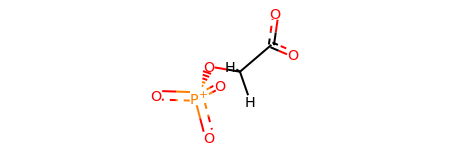

In [7]:
suppl = Chem.SDMolSupplier('DeepDock_2rka.sdf', sanitize=False)
mols = [mol for mol in suppl]
mols[-1]

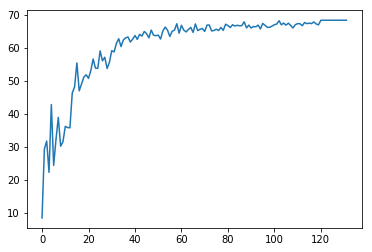

In [8]:
scores = [float(mol.GetProp('DeepDock_Score')) for mol in mols]
plt.plot(scores)

In [9]:
# Calcualte distances between ligand conformation and target
ligCoords_list = [torch.tensor(m.GetConformer().GetPositions()[opt.noHidx]) for m in [opt_mol]]
ligCoords = torch.stack(ligCoords_list).double()
#dist = self.compute_euclidean_distances_matrix(ligCoords, self.targetCoords).flatten().unsqueeze(1)
dist = torch.cdist(ligCoords, opt.targetCoords, 2).flatten().unsqueeze(1)

In [10]:
potentials = []
for i in [303, 969, 3237]:
    pi_data = pi[i].cpu().detach().numpy()
    mu_data = mu[i].cpu().detach().numpy()
    sigma_data = sigma[i].cpu().detach().numpy()
    
    x = np.linspace(0, 7.2, 100)

    oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi)
    p = pi_data.reshape(1, 10).repeat(len(x), 0)
    m = mu_data.reshape(1, 10).repeat(len(x), 0)
    s = sigma_data.reshape(1, 10).repeat(len(x), 0)
    x_r = x.repeat(10).reshape((-1, 10))

    result = (x_r - m) * np.reciprocal(s)
    result = -0.5 * (result * result)
    result = (np.exp(result) * np.reciprocal(s)) * oneDivSqrtTwoPI

    result = result * p
    result_sum = np.sum(result, axis=1)
    potentials.append(result_sum)

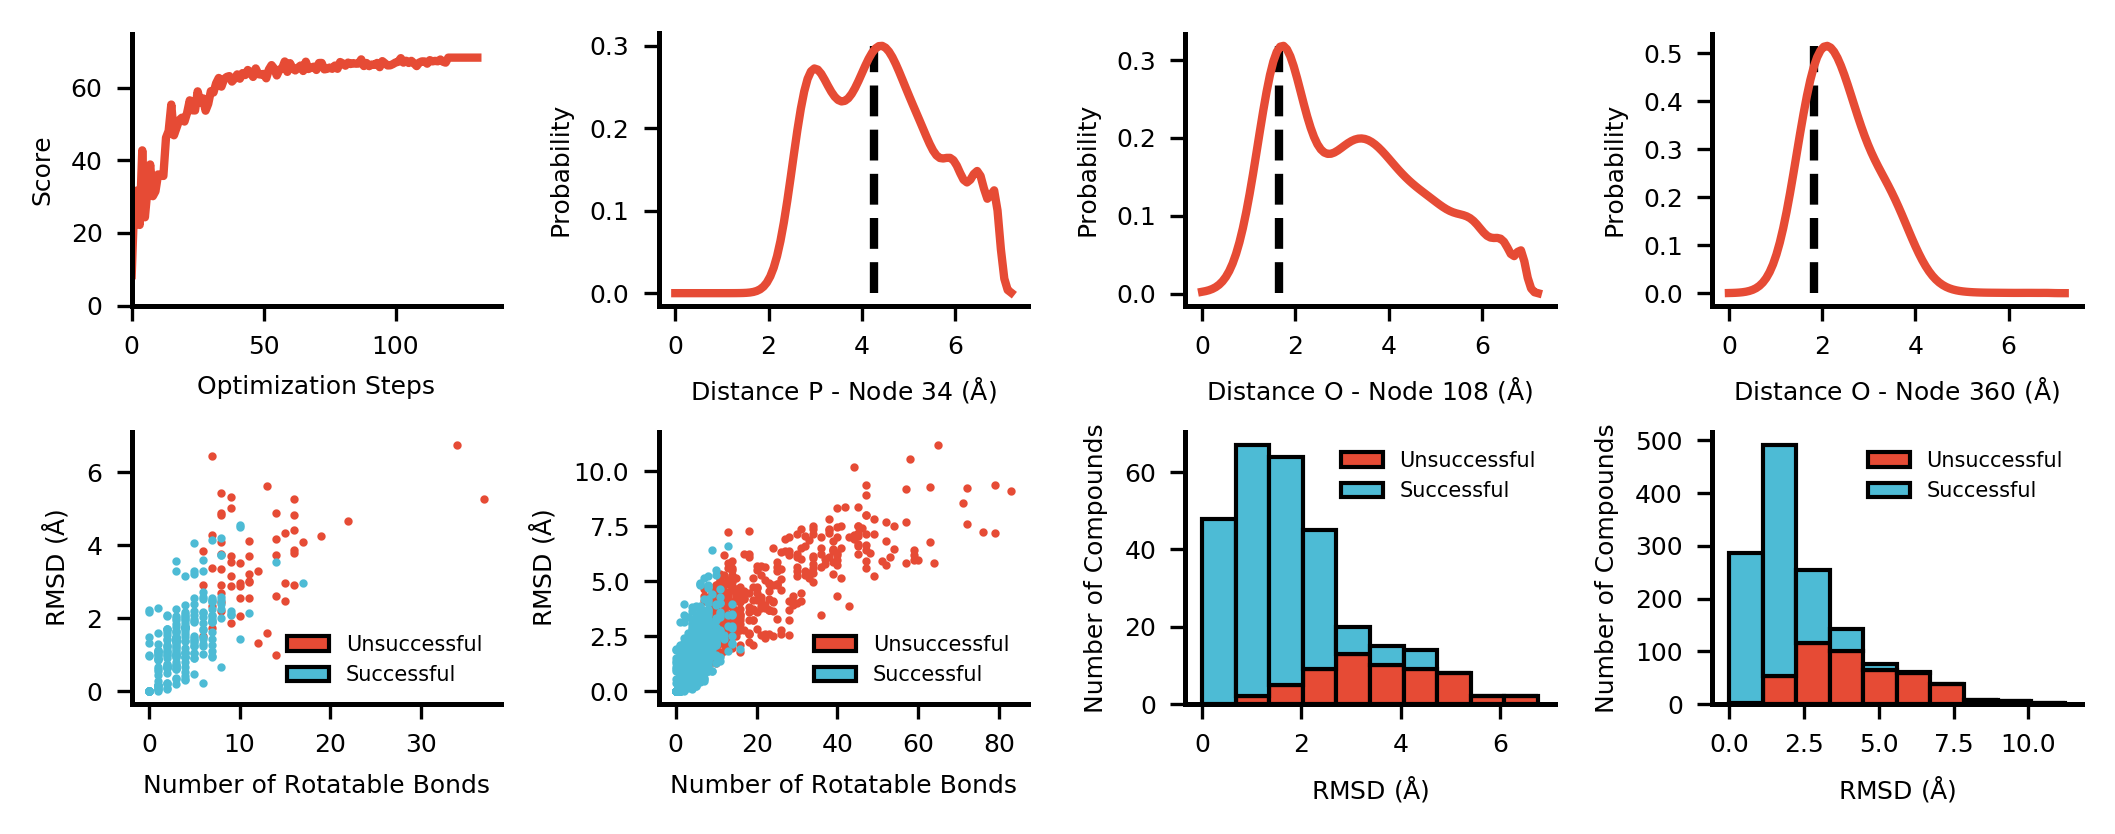

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

matplotlib.rcParams.update({'font.size': 5})
    
ligCoords_list = [torch.tensor(m.GetConformer().GetPositions()[opt.noHidx]) for m in [opt_mol]]
ligCoords = torch.stack(ligCoords_list).double()
dist = torch.cdist(ligCoords, opt.targetCoords, 2).flatten().unsqueeze(1)

style = 'nature-reviews.mplstyle'
with plt.style.context(style):
    matplotlib.rcParams.update({'xtick.labelsize': 6, 'ytick.labelsize': 6, 'font.size': 5,
                                'axes.titlesize': 6, 'axes.labelsize': 6})
    
    fig = plt.figure(figsize=(7, 2.73), dpi=300)

    ax1 = plt.subplot2grid((2, 4), (0, 0))
    ax2 = plt.subplot2grid((2, 4), (0, 1))
    ax3 = plt.subplot2grid((2, 4), (0, 2))
    ax4 = plt.subplot2grid((2, 4), (0, 3))
    ax5 = plt.subplot2grid((2, 4), (1, 0))
    ax6 = plt.subplot2grid((2, 4), (1, 1))
    ax7 = plt.subplot2grid((2, 4), (1, 2))
    ax8 = plt.subplot2grid((2, 4), (1, 3))

with plt.style.context(style):
    ax1.plot(scores)
ax1.set_xlabel('Optimization Steps')
ax1.set_ylabel('Score')
#ax1.set_title('Optimization')
ax1.set_xlim([0, np.ceil(len(mols)/10)*10])
ax1.set_ylim([0, 75])

with plt.style.context(style):
    ax2.plot(x, potentials[0])
    ax2.vlines(dist[303], potentials[0].min(), potentials[0].max(), linestyles='dashed')
ax2.set_xlabel('Distance P - Node 34 ($\mathrm{\AA}$)')
ax2.set_ylabel('Probability')
#ax2.set_title('P - Node 303')

with plt.style.context(style):
    ax3.plot(x, potentials[1])
    ax3.vlines(dist[969], potentials[1].min(), potentials[1].max(), linestyles='dashed')
ax3.set_xlabel('Distance O - Node 108 ($\mathrm{\AA}$)')
ax3.set_ylabel('Probability')
#ax3.set_title('O - Node 969')

with plt.style.context(style):
    ax4.plot(x, potentials[2])
    ax4.vlines(dist[3237], potentials[2].min(), potentials[2].max(), linestyles='dashed')
ax4.set_xlabel('Distance O - Node 360 ($\mathrm{\AA}$)')
ax4.set_ylabel('Probability')
#ax4.set_title('O - Node 33237')

d = torch.load('DockingResults_CASF2016_CoreSet.chk')
reults_casf = pd.DataFrame.from_dict(d)
norm_scores = [-r[0] if isinstance(r, list)  else -r for r in reults_casf.fun[reults_casf.success == True]]
with plt.style.context(style):
    ax5.scatter(reults_casf[reults_casf.success == False].num_rotbonds, reults_casf[reults_casf.success == False].rmsd, s=1)
    ax5.scatter(reults_casf[reults_casf.success == True].num_rotbonds, reults_casf[reults_casf.success == True].rmsd, s=1)
ax5.set_xlabel('Number of Rotatable Bonds')
ax5.set_ylabel('RMSD ($\mathrm{\AA}$)')
           
d = torch.load('DockingResults_TestSet.chk')
reults_test = pd.DataFrame.from_dict(d)
norm_scores = [-r[0] if isinstance(r, list)  else -r for r in reults_test.fun[reults_test.success == True]]
with plt.style.context(style):
    ax6.scatter(reults_test[reults_test.success == False].num_rotbonds, reults_test[reults_test.success == False].rmsd, s=1)
    ax6.scatter(reults_test[reults_test.success == True].num_rotbonds, reults_test[reults_test.success == True].rmsd, s=1)
ax6.set_xlabel('Number of Rotatable Bonds')
ax6.set_ylabel('RMSD ($\mathrm{\AA}$)')

with plt.style.context(style):
    ax7.hist([reults_casf['rmsd'][reults_casf.success == False], reults_casf['rmsd'][reults_casf.success == True]], 
             stacked=True)
ax7.set_xlabel('RMSD ($\mathrm{\AA}$)')
ax7.set_ylabel('Number of Compounds')
ax7.legend(['Unsuccessful', 'Successful'], frameon=False)

with plt.style.context(style):
    ax8.hist([reults_test['rmsd'][reults_test.success == False], reults_test['rmsd'][reults_test.success == True]], 
              stacked=True)
ax8.set_xlabel('RMSD ($\mathrm{\AA}$)')
ax8.set_ylabel('Number of Compounds')
ax8.legend(['Unsuccessful', 'Successful'], frameon=False)

ax5.legend(handles=ax8.legend_.legendHandles, labels = ['Unsuccessful', 'Successful'], frameon=False)
ax6.legend(handles=ax8.legend_.legendHandles, labels = ['Unsuccessful', 'Successful'], frameon=False)

plt.tight_layout()
#fig.savefig('image_plot/image_'+str(i).zfill(4)+'.png', dpi=300)
#plt.show()

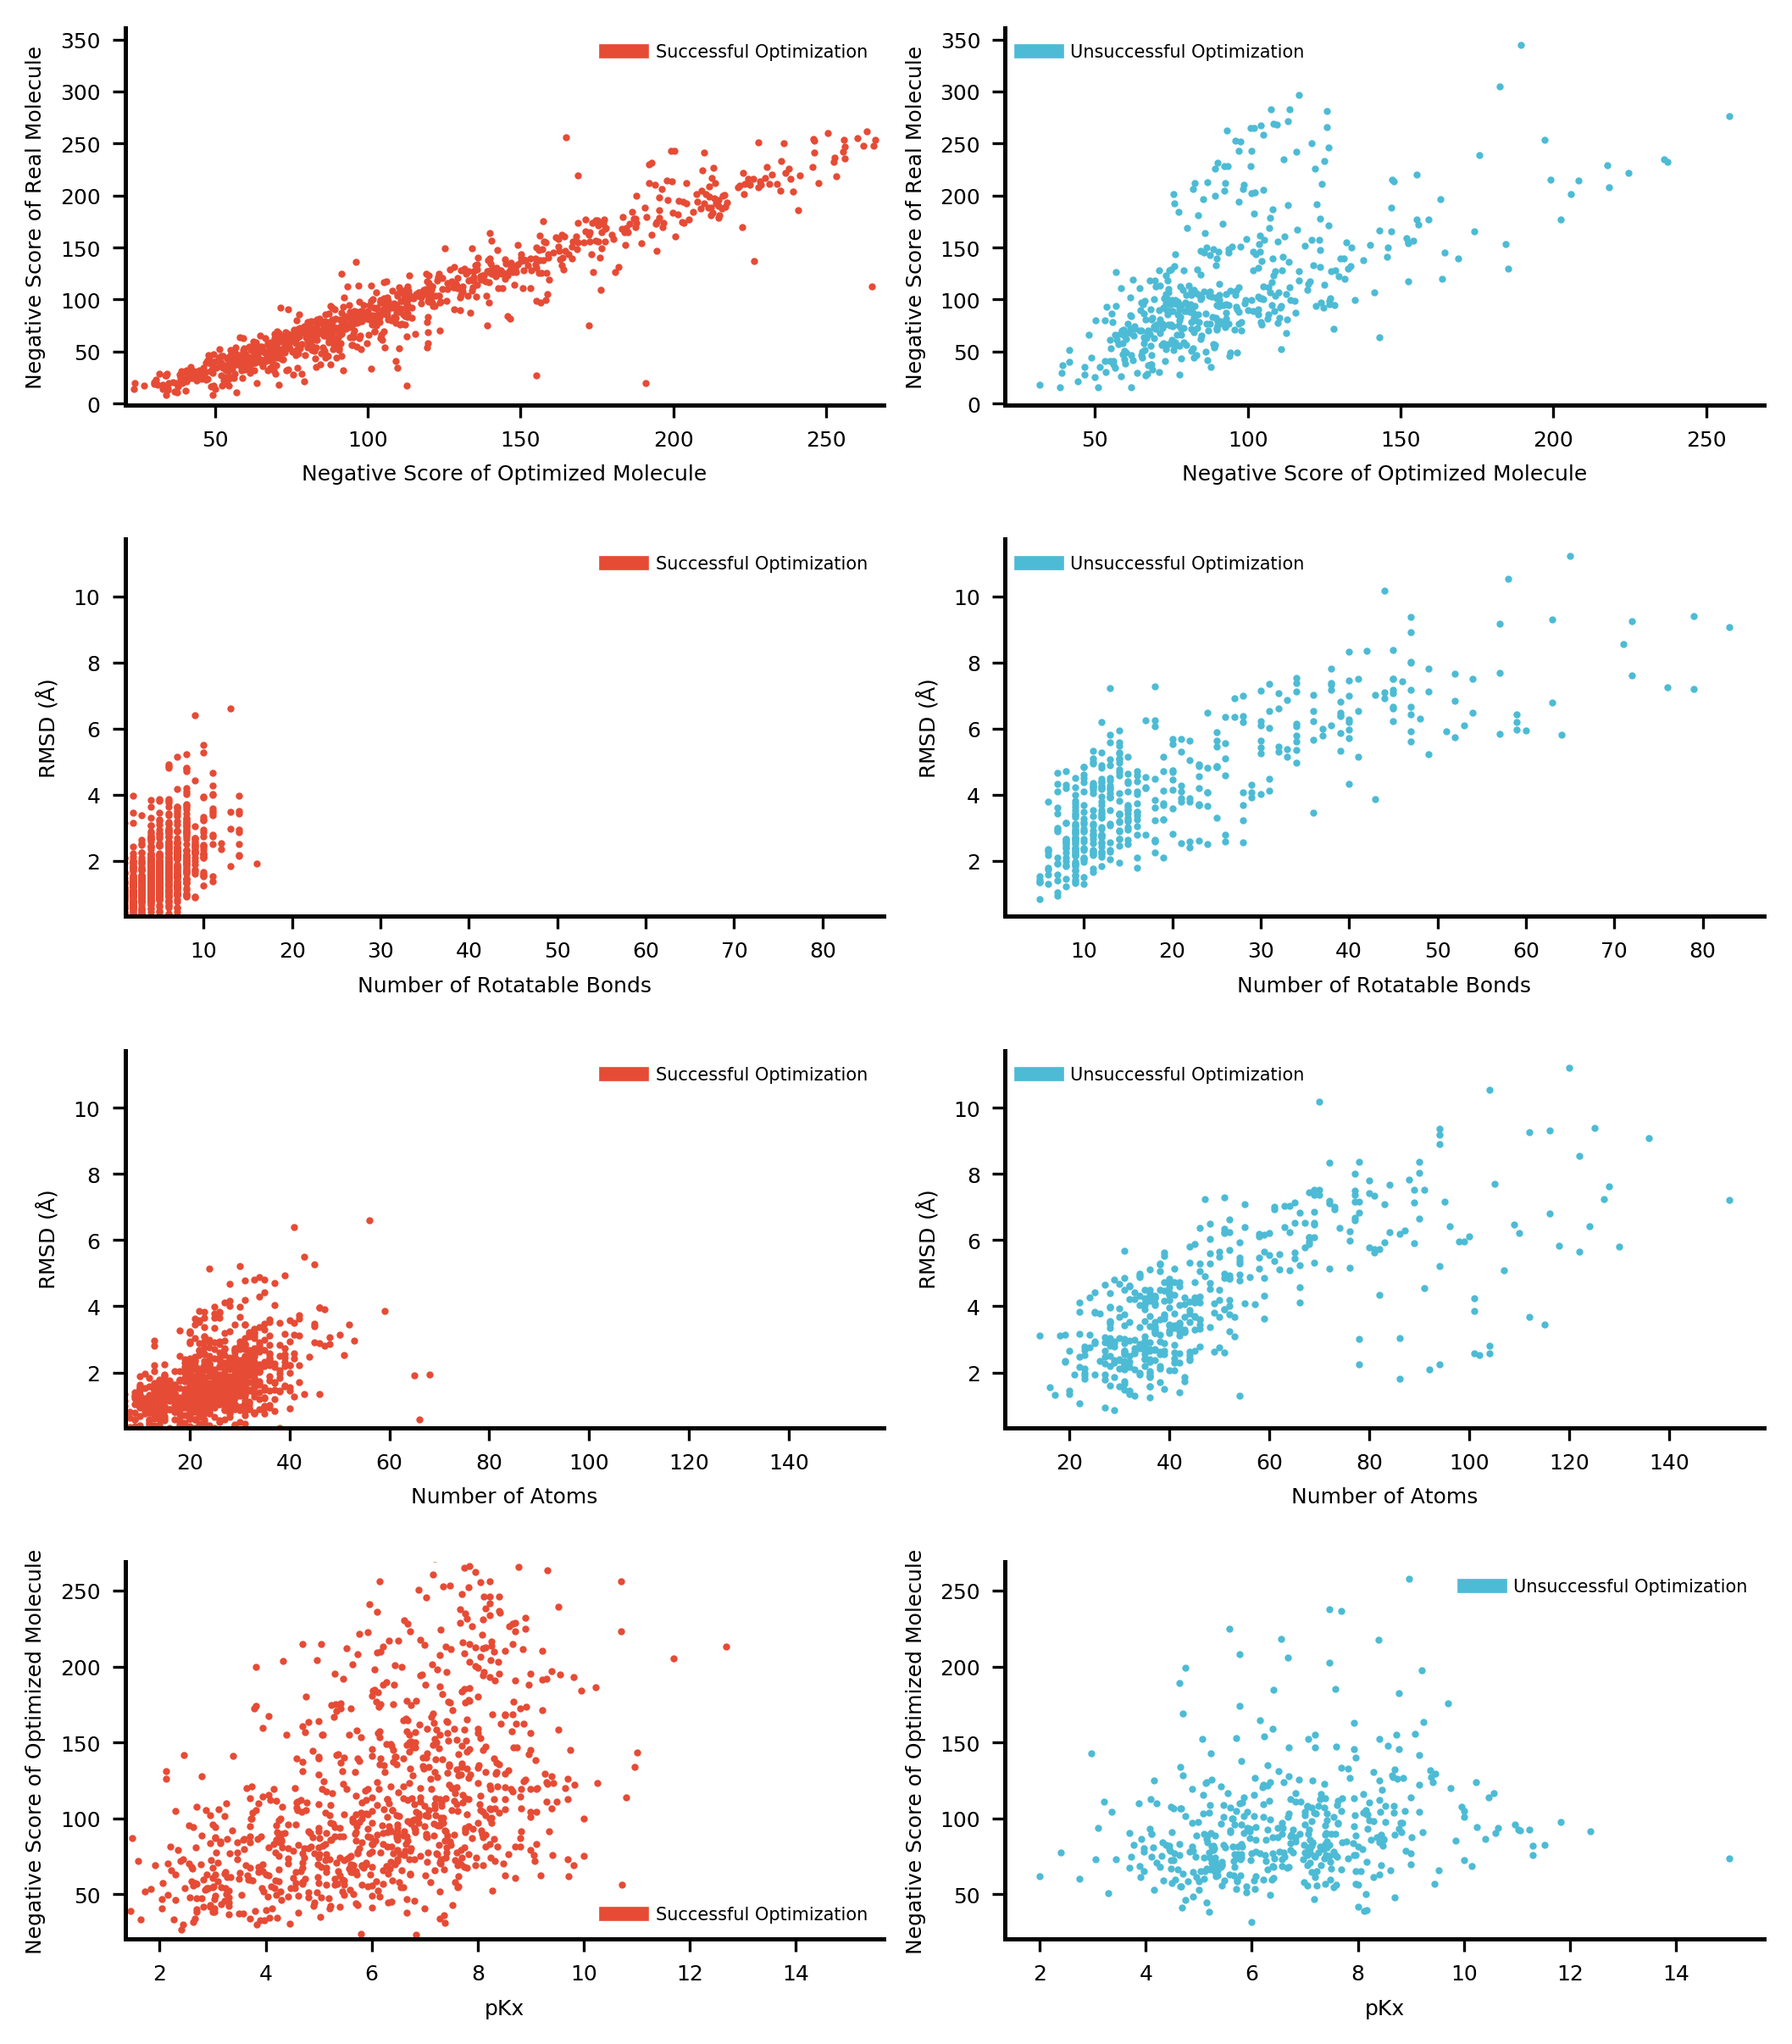

In [12]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
import torch

d = torch.load('DockingResults_TestSet.chk')
reults_test = pd.DataFrame.from_dict(d)
matplotlib.rcParams.update({'font.size': 5})

handle_successful = [Line2D([0], [0], color='#E64B35', lw=4)]
handle_unsuccessful = [Line2D([0], [0], color='#4DBBD5', lw=4)]
    
style = 'nature-reviews.mplstyle'
with plt.style.context(style):
    matplotlib.rcParams.update({'xtick.labelsize': 6, 'ytick.labelsize': 6, 'font.size': 5,
                                'axes.titlesize': 6, 'axes.labelsize': 6})
    
    fig = plt.figure(figsize=(7, 8), dpi=300)

    ax1 = plt.subplot2grid((4, 2), (0, 0))
    ax2 = plt.subplot2grid((4, 2), (0, 1))
    ax3 = plt.subplot2grid((4, 2), (1, 0))
    ax4 = plt.subplot2grid((4, 2), (1, 1))
    ax5 = plt.subplot2grid((4, 2), (2, 0))
    ax6 = plt.subplot2grid((4, 2), (2, 1))
    ax7 = plt.subplot2grid((4, 2), (3, 0))
    ax8 = plt.subplot2grid((4, 2), (3, 1))


with plt.style.context(style):    
    scores = [-r[0] if isinstance(r, list)  else -r for r in reults_test.fun[reults_test.success == True]]
    ax1.scatter(scores, reults_test[reults_test.success == True].score_real_mol, s=1)
ax1.set_xlabel('Negative Score of Optimized Molecule')
ax1.set_ylabel('Negative Score of Real Molecule')
ax1.legend(handle_successful, ['Successful Optimization'], frameon=False)

with plt.style.context(style):    
    scores = [-r[0] if isinstance(r, list)  else -r for r in reults_test.fun[reults_test.success == False]]
    ax2.scatter(scores, reults_test[reults_test.success == False].score_real_mol, s=1, color='#4DBBD5')
ax2.set_xlabel('Negative Score of Optimized Molecule')
ax2.set_ylabel('Negative Score of Real Molecule')
ax2.legend(handle_unsuccessful, ['Unsuccessful Optimization'], frameon=False)

ax1.set_xlim(ax2.get_xlim())
ax1.set_ylim(ax2.get_ylim())

with plt.style.context(style):
    ax3.scatter(reults_test[reults_test.success == True].num_rotbonds, reults_test[reults_test.success == True].rmsd, s=1)
ax3.set_xlabel('Number of Rotatable Bonds')
ax3.set_ylabel('RMSD ($\mathrm{\AA}$)')
ax3.legend(handle_successful, ['Successful Optimization'], frameon=False)

with plt.style.context(style):
    ax4.scatter(reults_test[reults_test.success == False].num_rotbonds, reults_test[reults_test.success == False].rmsd, s=1, color='#4DBBD5')
ax4.set_xlabel('Number of Rotatable Bonds')
ax4.set_ylabel('RMSD ($\mathrm{\AA}$)')
ax4.legend(handle_unsuccessful, ['Unsuccessful Optimization'], frameon=False)

ax3.set_xlim(ax4.get_xlim())
ax3.set_ylim(ax4.get_ylim())

with plt.style.context(style):
    ax5.scatter(reults_test[reults_test.success == True].num_atoms, reults_test[reults_test.success == True].rmsd, s=1)
ax5.set_xlabel('Number of Atoms')
ax5.set_ylabel('RMSD ($\mathrm{\AA}$)')
ax5.legend(handle_successful, ['Successful Optimization'], frameon=False)

with plt.style.context(style):
    ax6.scatter(reults_test[reults_test.success == False].num_atoms, reults_test[reults_test.success == False].rmsd, s=1, color='#4DBBD5')
ax6.set_xlabel('Number of Atoms')
ax6.set_ylabel('RMSD ($\mathrm{\AA}$)')
ax6.legend(handle_unsuccessful, ['Unsuccessful Optimization'], frameon=False)

ax5.set_xlim(ax6.get_xlim())
ax5.set_ylim(ax6.get_ylim())

with plt.style.context(style):    
    scores = [-r[0] if isinstance(r, list)  else -r for r in reults_test.fun[reults_test.success == True]]
    ax7.scatter(reults_test[reults_test.success == True].pkx, scores, s=1)
ax7.set_xlabel('pKx')
ax7.set_ylabel('Negative Score of Optimized Molecule')
ax7.legend(handle_successful, ['Successful Optimization'], frameon=False)


with plt.style.context(style):    
    scores = [-r[0] if isinstance(r, list)  else -r for r in reults_test.fun[reults_test.success == False]]
    ax8.scatter(reults_test[reults_test.success == False].pkx, scores, s=1, color='#4DBBD5')
ax8.set_xlabel('pKx')
ax8.set_ylabel('Negative Score of Optimized Molecule')
ax8.legend(handle_unsuccessful, ['Unsuccessful Optimization'], frameon=False)

ax7.set_xlim(ax8.get_xlim())
ax7.set_ylim(ax8.get_ylim())

plt.tight_layout()



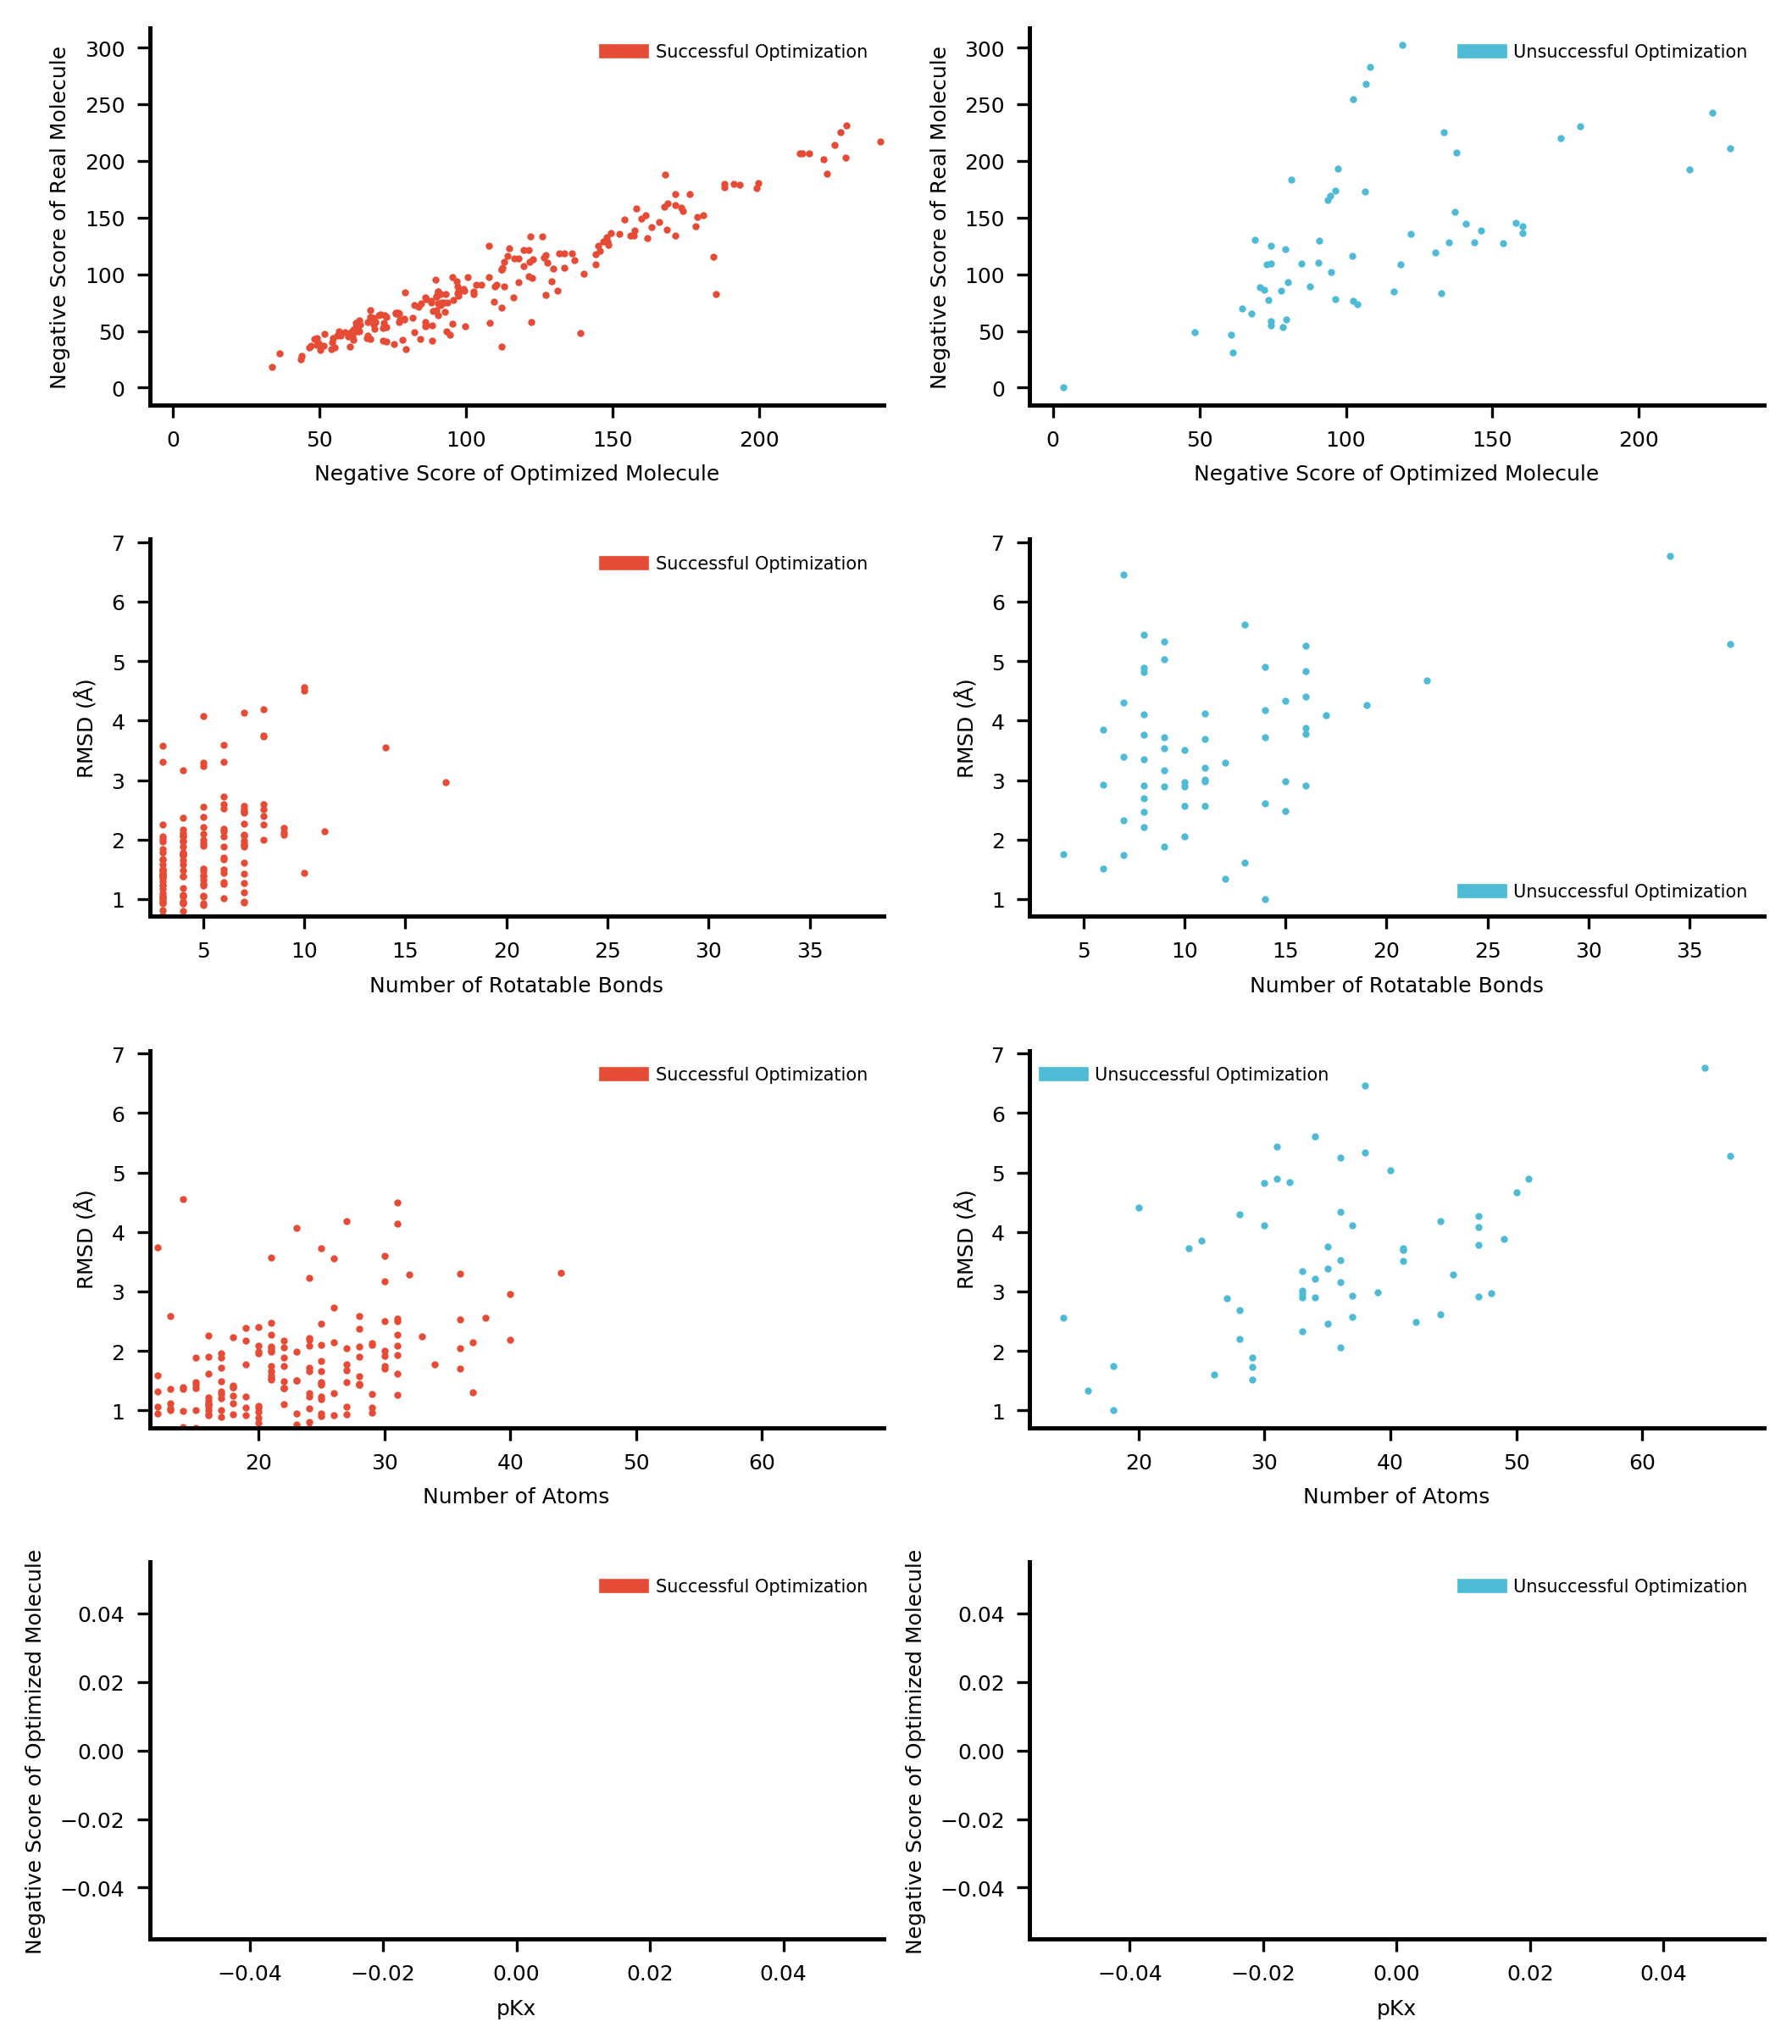

In [15]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
import torch

d = torch.load('DockingResults_CASF2016_CoreSet.chk')
reults_test = pd.DataFrame.from_dict(d)
matplotlib.rcParams.update({'font.size': 5})

handle_successful = [Line2D([0], [0], color='#E64B35', lw=4)]
handle_unsuccessful = [Line2D([0], [0], color='#4DBBD5', lw=4)]
    
style = 'nature-reviews.mplstyle'
with plt.style.context(style):
    matplotlib.rcParams.update({'xtick.labelsize': 6, 'ytick.labelsize': 6, 'font.size': 5,
                                'axes.titlesize': 6, 'axes.labelsize': 6})
    
    fig = plt.figure(figsize=(7, 8), dpi=300)

    ax1 = plt.subplot2grid((4, 2), (0, 0))
    ax2 = plt.subplot2grid((4, 2), (0, 1))
    ax3 = plt.subplot2grid((4, 2), (1, 0))
    ax4 = plt.subplot2grid((4, 2), (1, 1))
    ax5 = plt.subplot2grid((4, 2), (2, 0))
    ax6 = plt.subplot2grid((4, 2), (2, 1))
    ax7 = plt.subplot2grid((4, 2), (3, 0))
    ax8 = plt.subplot2grid((4, 2), (3, 1))


with plt.style.context(style):    
    scores = [-r[0] if isinstance(r, list)  else -r for r in reults_test.fun[reults_test.success == True]]
    ax1.scatter(scores, reults_test[reults_test.success == True].score_real_mol, s=1)
ax1.set_xlabel('Negative Score of Optimized Molecule')
ax1.set_ylabel('Negative Score of Real Molecule')
ax1.legend(handle_successful, ['Successful Optimization'], frameon=False)

with plt.style.context(style):    
    scores = [-r[0] if isinstance(r, list)  else -r for r in reults_test.fun[reults_test.success == False]]
    ax2.scatter(scores, reults_test[reults_test.success == False].score_real_mol, s=1, color='#4DBBD5')
ax2.set_xlabel('Negative Score of Optimized Molecule')
ax2.set_ylabel('Negative Score of Real Molecule')
ax2.legend(handle_unsuccessful, ['Unsuccessful Optimization'], frameon=False)

ax1.set_xlim(ax2.get_xlim())
ax1.set_ylim(ax2.get_ylim())

with plt.style.context(style):
    ax3.scatter(reults_test[reults_test.success == True].num_rotbonds, reults_test[reults_test.success == True].rmsd, s=1)
ax3.set_xlabel('Number of Rotatable Bonds')
ax3.set_ylabel('RMSD ($\mathrm{\AA}$)')
ax3.legend(handle_successful, ['Successful Optimization'], frameon=False)

with plt.style.context(style):
    ax4.scatter(reults_test[reults_test.success == False].num_rotbonds, reults_test[reults_test.success == False].rmsd, s=1, color='#4DBBD5')
ax4.set_xlabel('Number of Rotatable Bonds')
ax4.set_ylabel('RMSD ($\mathrm{\AA}$)')
ax4.legend(handle_unsuccessful, ['Unsuccessful Optimization'], frameon=False)

ax3.set_xlim(ax4.get_xlim())
ax3.set_ylim(ax4.get_ylim())

with plt.style.context(style):
    ax5.scatter(reults_test[reults_test.success == True].num_atoms, reults_test[reults_test.success == True].rmsd, s=1)
ax5.set_xlabel('Number of Atoms')
ax5.set_ylabel('RMSD ($\mathrm{\AA}$)')
ax5.legend(handle_successful, ['Successful Optimization'], frameon=False)

with plt.style.context(style):
    ax6.scatter(reults_test[reults_test.success == False].num_atoms, reults_test[reults_test.success == False].rmsd, s=1, color='#4DBBD5')
ax6.set_xlabel('Number of Atoms')
ax6.set_ylabel('RMSD ($\mathrm{\AA}$)')
ax6.legend(handle_unsuccessful, ['Unsuccessful Optimization'], frameon=False)

ax5.set_xlim(ax6.get_xlim())
ax5.set_ylim(ax6.get_ylim())

with plt.style.context(style):    
    scores = [-r[0] if isinstance(r, list)  else -r for r in reults_test.fun[reults_test.success == True]]
    ax7.scatter(reults_test[reults_test.success == True].pkx, scores, s=1)
ax7.set_xlabel('pKx')
ax7.set_ylabel('Negative Score of Optimized Molecule')
ax7.legend(handle_successful, ['Successful Optimization'], frameon=False)


with plt.style.context(style):    
    scores = [-r[0] if isinstance(r, list)  else -r for r in reults_test.fun[reults_test.success == False]]
    ax8.scatter(reults_test[reults_test.success == False].pkx, scores, s=1, color='#4DBBD5')
ax8.set_xlabel('pKx')
ax8.set_ylabel('Negative Score of Optimized Molecule')
ax8.legend(handle_unsuccessful, ['Unsuccessful Optimization'], frameon=False)

ax7.set_xlim(ax8.get_xlim())
ax7.set_ylim(ax8.get_ylim())

plt.tight_layout()

